Source: https://github.com/jeffheaton/app_deep_learning/blob/854a0e4a3982daea4e50d34e4d8fc0d9d806b960/t81_558_class_03_4_early_stop.ipynb

In [2]:
from IPython.display import Image

### Early stopping and Network Persistence
Early stopping is a technique that helps prevent overfitting and optimize model performance by monitoring validation loss during training. We can avoid un necessary iterations and save computational resources by stopping the training process when the validation loss starts increasing.

It can be diffucult to determine how many ephocs to cycle through to train a neural network. Overfitting will occur if you train the neural network for too many ephocs, and the neural network will not perform well on new data, despite attaining a good accuracy on the training set. Overfitting occurs when a neural network is trained to the point that it begins to memorize rather than generalize, as showed in Figrue 1. 

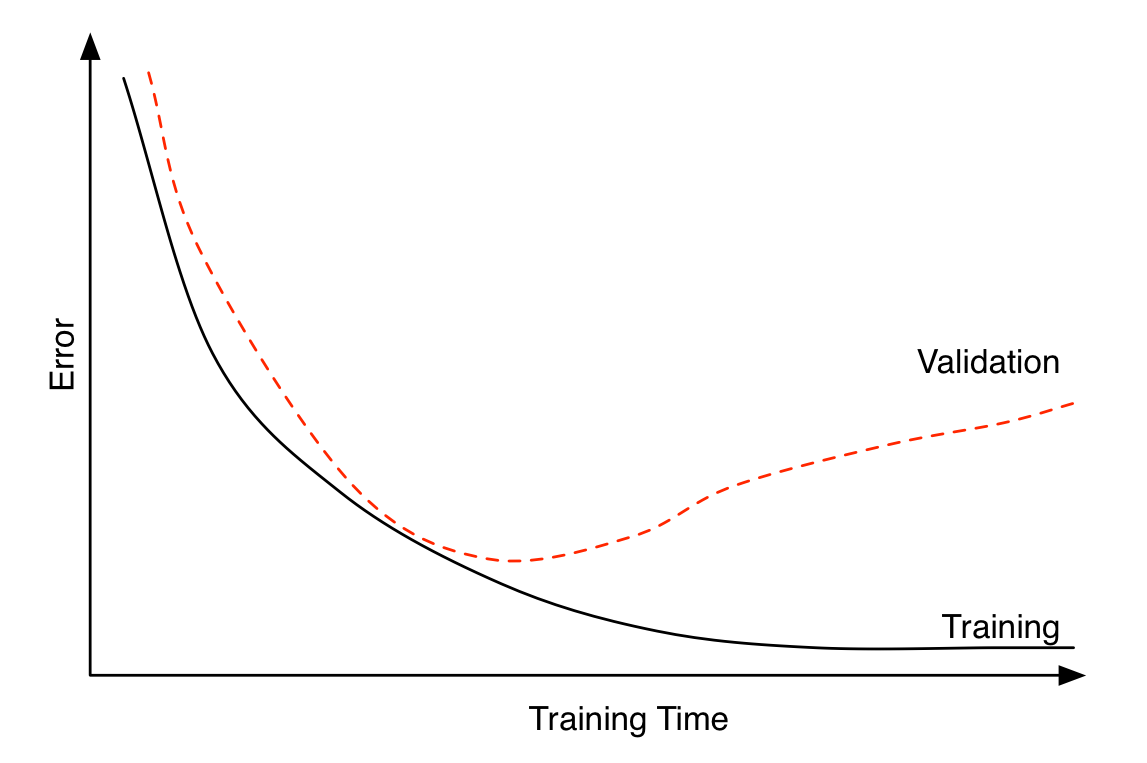

In [3]:
# Figure 1
Image("images/training_error_overfitting.png")

It is important to segment the original dataset into several datasets:

- Training Set
- Validation Set
- Holdout Set

You can construct these sets in several different ways. The following programs demonstrate some of these.

The first method is a training and validation set. We use the training data to train the neural network until the validation set no longer improves. This attemps to stop at a near-optimal training point. This method will only give accurate "out of sample" predictions for the validation set; this is usually 20% of the data. The predictions for the training data will be overly optimistic, as these were the data that we used to train the neural network. Figure 2 represents the data division.

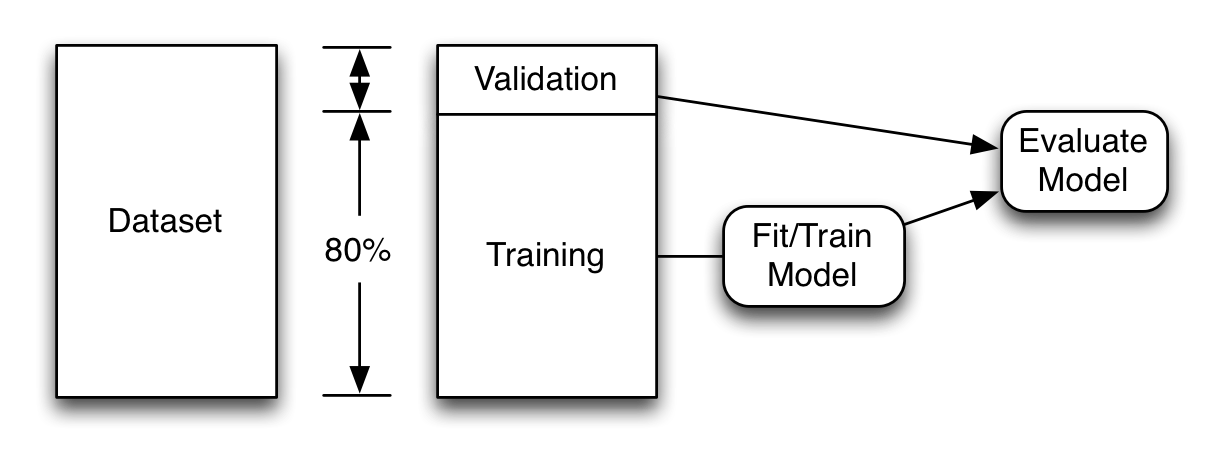

In [5]:
Image("images/data_division.png")

Because pytorch does not include a built-in early stopping function, we must define one of our own. We will use the following EarlyStopping class. 

We can provide several parameters to the EarlyStopping object:

- min_delta: this value should be kept small; it specifies the minimum change that should be considered an improvement. Setting it even smaller will not likely have a great deal of impact.
- patience: how long should the training wait for the validation error to improve?
- restore_best_weights: you should usually set this to true, as it restores the weights to the values they were at when the validation set is the highest

class definition

In [ ]:
import copy

class EarlyStopping:
    def __init__(self, patience=5, min_delta=0, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_model = None
        self.best_loss = None
        self.counter = 0
        self.status = ""
        
    def __call__(self, model, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model = copy.deepcopy(model.state_dict())
        elif self.best_loss - val_loss >= self.min_delta:
            self.best_model = copy.deepcopy(model.state_dict())
            self.best_loss = val_loss
            self.counter = 0
            self.status = f"Improvement found, counter reset to {self.counter}"
        else:
            self.counter += 1
            self.status = f"NO improvement found, in the last {self.counter} epochs"
            if self.counter >= self.patience:
                self.status = f"Early stopping triggered after {self.counter} epochs"
                if self.restore_best_weights:
                    model.load_state_dict(self.best_model) 
                return True
        return False

### Early stopping with classification 
We will now see an example of classification training with early stopping. We will train the neural network until the error no longer improve on the validation set.

In [4]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
# read the MPG dataset
df = pd.read_csv("data/auto-mpg.csv", na_values=["NA", "?"])

# save the cars name
cars = df["name"]

In [ ]:
# check for missing values
# check for missing values
missing_values = df.isnull().sum()
print(missing_values)

In [ ]:
# handle missing values
df["horsepower"] = df["horsepower"].fillna(df["horsepower"].median())

In [ ]:
# select pytorch device
has_mps = torch.backends.mps.is_built()
device = "mps" if has_mps else "cuda" if torch.cuda.is_available() else "cpu"
print(device)

In [ ]:
# pandas to numpy 
x = df[
    [
        "cylinders",
        "displacement",
        "horsepower",
        "weight",
        "acceleration",
        "year",
        "origin"
    ]
].values.astype(np.float32)

y = df["mpg"].values.astype(np.float32)
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.25, random_state=42)

# numpy to torch tensor
x_train = torch.tensor(x_train, device=device, dtype=torch.float32)
y_train = torch.tensor(y_train, device=device, dtype=torch.float32)

x_test = torch.tensor(x_test, device=device, dtype=torch.float32)
y_test = torch.tensor(y_test, device=device, dtype=torch.float32)

batch_size = 20

dataset_train = TensorDataset(x_train, y_train)
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

dataset_test = TensorDataset(x_test, y_test)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)

# the model instance must have the name "model"
model = nn.Sequential(
    nn.Linear(x_train.shape[1], 50),
    nn.ReLU(),
    nn.Linear(50, 25),
    nn.ReLU(),
    nn.Linear(25, 1),
).to(device)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
es = EarlyStopping()

In [ ]:
epochs = 50
training_loss = []
validation_loss = []
for epoch in range(epochs):
    model.train()
    for x_batch, y_batch in dataloader_train:
        optimizer.zero_grad()
        output = model(x_batch)
        loss = loss_fn(output, y_batch)
        training_loss.append(loss.item())
        loss.backward()
        optimizer.step()
        
    # validation step
    model.eval()
    with torch.no_grad():
        val_output = model(x_test)
        val_loss = loss_fn(val_output, y_test)
        validation_loss.append(val_loss.item())
        
    print(f"Epoch {epoch}/{epochs}, Tra loss {training_loss[epoch]:.4f}, Val loss {validation_loss[epoch]:.4f}, ")
    

In [ ]:
# train algorithm
epoch = 0
done = False
while epoch < 100 and not done:
    epoch += 1
    steps = list(enumerate(dataloader_train))
    pbar = tqdm.tqdm(steps)
    model.train()
    for i, (x_batch, y_batch) in pbar:
        # forward pass
        y_batch_pred = model(x_batch).flatten()
        loss = loss_fn(y_batch_pred, y_batch)
        
        # restore the gradient for the next calculation
        optimizer.zero_grad()
        
        # backward pass
        loss.backward()
        
        # update model parameters
        optimizer.step()
        
        loss = loss.item()
        if i == len(steps) - 1:
            model.eval()
            pred = model(x_test).flatten()
            vloss = loss_fn(pred, y_test)
            if es(model, vloss):
                done = True
            pbar.set_description(f"Epoch: {epoch}, t_loss: {loss:.2f}, v_loss: {vloss:.2f}, EStop:[{es.status}]")
        else: 
            pbar.set_description(f"Epoch: {epoch}, t_loss: {loss:.2f}")

In [ ]:
from sklearn import metrics

# measure RMSE error
pred = model(x_test)
score = torch.sqrt(torch.nn.functional.mse_loss(pred.flatten(), y_test))
print(f"Final score (RMSE): {score}")

### Early stopping with classification
Example of classification with early stopping. We will train the neural network until the error no longer improves on the validation set.

In [2]:
import numpy as np
import torch
import pandas as pd
import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

In [3]:
# set random seed
np.random.seed(42)
torch.manual_seed(42)


df = pd.read_csv("data/iris.csv", na_values=["NA", "?"])
le = LabelEncoder()
    
# extracting the training features
x = df[["sepal_l", "sepal_w", "petal_l", "petal_w"]].values
    
# processing the labels
y = le.fit_transform(df["species"])
print(y)
species = le.classes_

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


In [ ]:
# split into validation and training sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

The statement scaler = StandardScaler() is used to standardize the features of the dataset before training the neural network. The StandardScaler is a preprocessing technique from the scikit-learn library, which standardizes features by removing the mean and scaling to unit variance.

Why Standardize the Features?
- Consistent Scale: Neural networks are sensitive to the scale of the input features. Features with vastly different scales can lead to an unstable training process. Standardizing the data ensures that each feature contributes equally to the training process by having a consistent scale.

- Faster Convergence: Standardized data can help the optimizer converge faster to a minimum, as it can navigate the cost function's surface more effectively when the input features are on a similar scale.

- Improved Performance: Standardization can often lead to improved model performance, as it prevents certain features from dominating the learning process solely due to their scale.

scaler.fit_transform(x_train): Fits the scaler to the training data and transforms it, standardizing the features by subtracting the mean and scaling to unit variance.

scaler.transform(x_test): Transforms the test data using the parameters (mean and variance) computed from the training data. This ensures that the test set is scaled in the same way as the training set, maintaining consistency.
This process helps the neural network learn effectively and improves the overall model's robustness and accuracy.

In [ ]:
device = "cpu"

# numpy to torch tensor
x_train = torch.tensor(x_train, device=device, dtype=torch.float32)
y_train = torch.tensor(y_train, device=device, dtype=torch.long)

x_test = torch.tensor(x_test, device=device, dtype=torch.float32)
y_test = torch.tensor(y_test, device=device, dtype=torch.long)

# create torch datasets
batch_size = 16

dataset_train = TensorDataset(x_train, y_train)
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

dataset_test = TensorDataset(x_test, y_test)
dataloader_test = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

In [ ]:
# create the model using Sequential
print(x_train.shape[1])
model = nn.Sequential(
    nn.Linear(x_train.shape[1], 50),
    nn.ReLU(),
    nn.Linear(50, 25),
    nn.ReLU(),
    nn.Linear(25, len(species)),
    nn.LogSoftmax(dim=1)
)

In [ ]:
# loss function definition
loss_fn = nn.CrossEntropyLoss()

# optimizer definition
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# early stop instance
early_stop = EarlyStopping()

In [ ]:
# train algorithm
epoch = 0
done = False
while epoch < 100 and not done:
    epoch += 1
    steps = list(enumerate(dataloader_train)) # list of tuples (batch_id, [x_batch_id, y_batch_id]) 
    pbar = tqdm.tqdm(steps)
    model.train()
    for i, (x_batch, y_batch) in pbar:
        y_batch_pred = model(x_batch.to(device))
        loss = loss_fn(y_batch_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        loss = loss.item()
        # if the control get the last batch of the current epoch 
        if i == len(steps) - 1:
            model.eval()
            pred = model(x_test)
            vloss = loss_fn(pred, y_test)
            if early_stop(model, vloss):
                done = True
            pbar.set_description(f"Epoch: {epoch}, t_loss {loss:.2f}, v_loss {vloss:.2f}, {early_stop.status}")
        else:
            pbar.set_description(f"Epoch: {epoch}, t_loss {loss:.2f}")

In [ ]:
pred = model(x_test)
vloss = loss_fn(pred, y_test)
print(f"Loss = {vloss}")